<a href="https://colab.research.google.com/github/smartdesignlab/SDL_teaching/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network (CNN)

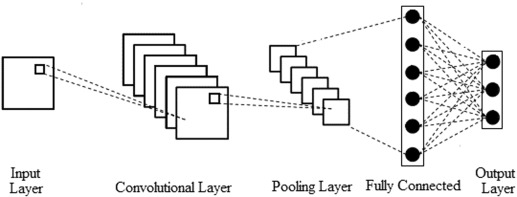

In [14]:
''' import '''
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.functional.regression import mean_squared_error, mean_absolute_percentage_error, pearson_corrcoef
from torchsummary import summary

from sklearn.preprocessing import MinMaxScaler

from utils import set_all, load_data, split_data, check_data, train, evaluate, plot_hist

In [15]:
''' set '''
device, data_path, output_path = set_all(os.getcwd())

In [16]:
''' load data '''
X, Y = load_data(data_path, '500')
X = X / 255.0

scaler = MinMaxScaler()
X_tr, X_ts, Y_tr, Y_ts = split_data(X,Y, test_size=0.2, device=device, scaler=scaler)

print(X_tr.shape, X_ts.shape)
print (Y_tr.shape,Y_ts.shape)

torch.Size([400, 1, 56, 56]) torch.Size([100, 1, 56, 56])
torch.Size([400, 1]) torch.Size([100, 1])


In [17]:
# check_data(X,Y)

In [18]:
''' model '''
class CNN(nn.Module):
    def __init__(self, conv_chs=[16, 32, 64], fc_fts=[256, 1]):
        super(CNN, self).__init__()

        # conv_chs=[1, 16, 32, 64], fc_fts=[256, 1]
        num_conv_layers = len(conv_chs)

        # convs
        self.convs = nn.ModuleList()
        in_ch = 1

        for i in range(num_conv_layers):
            out_ch = conv_chs[i]
            self.convs.append(nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1))
            in_ch = out_ch

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)

        # calculate the size of the flattened feature map after the convolutional layers
        final_feature_map_size = 56 // (2 ** num_conv_layers)
        conv_output_size = in_ch * final_feature_map_size * final_feature_map_size

        # fcs
        self.flatten = nn.Flatten()  # flatten the feature map to prepare for fully connected layers
        self.fcs = nn.ModuleList()
        in_ft = conv_output_size
        for fc_unit in fc_fts[:-1]:  # create the hidden fully connected layers
            self.fcs.append(nn.Linear(in_ft, fc_unit))
            in_ft = fc_unit  # update input size for the next fully connected layer

        # define the output layer
        self.fc_out = nn.Linear(in_ft, fc_fts[-1])

    def forward(self, x):
        # pass the input through the convolutional layers with ReLU and MaxPooling
        for conv in self.convs:
            x = self.relu(conv(x))
            x = self.maxpool(x)

        # flatten the output from the convolutional layers
        x = self.flatten(x)

        # pass the flattened output through the fully connected layers with ReLU
        for fc in self.fcs:
            x = self.relu(fc(x))

        # pass the output through the final layer
        x = self.fc_out(x)

        return x

In [19]:
# cnn = CNN().to(device)

# summary(cnn, (1, 56, 56))
# cnn

In [21]:
''' hyper params '''

# model
cnn = CNN(conv_chs=[1, 16, 32, 64], fc_fts=[256, 1]).to(device)

# hyper param
num_epochs = 100
batch_size = 64
learning_rate = 1e-3

# loss, optim, scaduler
criterion = nn.MSELoss()
optimizer = optim.Adam(params=cnn.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.9)

# data loader
train_loader = DataLoader(TensorDataset(X_tr, Y_tr), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_ts, Y_ts), batch_size=len(X_ts))

In [22]:
''' train '''
loss_tr_hist = []
loss_val_hist = []

for epoch in range(num_epochs):

    # train, valid
    loss_tr = train(cnn, train_loader, criterion, optimizer)
    loss_val = evaluate(cnn, test_loader, criterion)
    scheduler.step()
    
    # history
    loss_tr_hist.append(loss_tr)
    loss_val_hist.append(loss_val)
    print(f'Epoch [{epoch+1:3}/{num_epochs}], Tr loss: {loss_tr:.5f}, Val loss: {loss_val:.5f}')

Epoch [  1/100], Tr loss: 0.17331, Val loss: 0.08580
Epoch [  2/100], Tr loss: 0.08328, Val loss: 0.08963
Epoch [  3/100], Tr loss: 0.08020, Val loss: 0.06109
Epoch [  4/100], Tr loss: 0.07614, Val loss: 0.06635
Epoch [  5/100], Tr loss: 0.07368, Val loss: 0.05952
Epoch [  6/100], Tr loss: 0.07487, Val loss: 0.06266
Epoch [  7/100], Tr loss: 0.07423, Val loss: 0.06054
Epoch [  8/100], Tr loss: 0.07348, Val loss: 0.05979
Epoch [  9/100], Tr loss: 0.07428, Val loss: 0.06239
Epoch [ 10/100], Tr loss: 0.07284, Val loss: 0.06201
Epoch [ 11/100], Tr loss: 0.07395, Val loss: 0.06011
Epoch [ 12/100], Tr loss: 0.07272, Val loss: 0.06276
Epoch [ 13/100], Tr loss: 0.07185, Val loss: 0.06009
Epoch [ 14/100], Tr loss: 0.07337, Val loss: 0.06307
Epoch [ 15/100], Tr loss: 0.07003, Val loss: 0.05947
Epoch [ 16/100], Tr loss: 0.07385, Val loss: 0.06421
Epoch [ 17/100], Tr loss: 0.07367, Val loss: 0.05879
Epoch [ 18/100], Tr loss: 0.07248, Val loss: 0.06298
Epoch [ 19/100], Tr loss: 0.07053, Val loss: 0

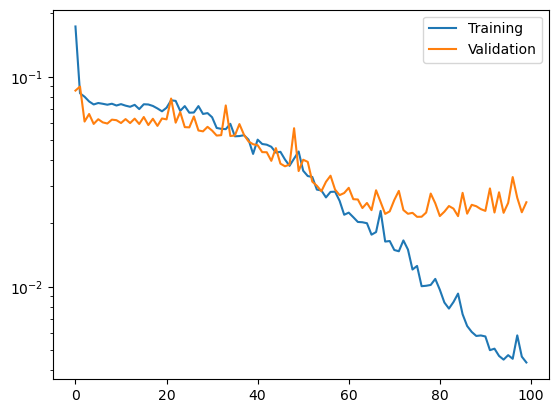

In [23]:
plot_hist(loss_tr_hist, loss_val_hist)

valid RMSE :  0.1588
valid MAPE :  0.3226
valid R2   :  0.8174


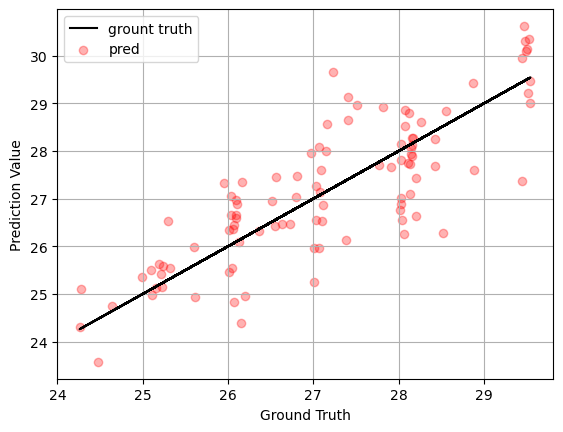

In [24]:
''' evaluation '''
cnn.eval()
y_pred = cnn(X_ts)

rmse = mean_squared_error(y_pred, Y_ts, squared=False).item()
mape = mean_absolute_percentage_error(Y_ts, y_pred).item()
r2 = pearson_corrcoef(Y_ts, y_pred).item()


# invers transform
y_pred = y_pred.cpu().detach()
y_pred = scaler.inverse_transform(y_pred)

y_ts = Y_ts.cpu()
y_ts = scaler.inverse_transform(y_ts)


# plot
plt.plot(y_ts, y_ts, c='black')
plt.scatter(y_ts, y_pred, alpha=0.3, color='red')

plt.legend(['grount truth','pred'])
plt.xlabel('Ground Truth')
plt.ylabel('Prediction Value')
plt.grid()

print("valid RMSE : " , np.round(rmse,4))
print("valid MAPE : " , np.round(mape,4))
print("valid R2   : " , np.round(r2,4))